# **Loading the Data**
The data is present in a google drive folder, we need to load that data in colab. For that, we need to upload that data to our own google drive (maybe adding a shortcut of that data file to our drive, our downloading it and uploading it)

In [ ]:
import torch 

In [ ]:
 from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pipreqs

/bin/bash: pipreqs: command not found


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/ES_FaceMatch_Dataset'
!ls {PATH_OF_DATA}

ROOT_DIR = 'gdrive/My Drive/ES_FaceMatch_Dataset'
IMG_DIR = 'dataset_images'
TRAIN_DIR = 'train.csv'
TEST_DIR = 'test.csv'
# Have already cropped all the images and saved it in a zip file called images.zip
ZIP_FILE_DIR = '/content/gdrive/My Drive/images.zip'

dataset_images	test.csv  train.csv


In [ ]:
import os
os.getcwd()

'/content'

# **Create a custom Data Class**
Use a custom PyTorch data object - for each image pair since we need to load a pair of images with labels.

In [ ]:
import pandas as pd
import numpy as np
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils

# Defining a custom PyTorch Dataset Class to represent a pair of images
class imagePairs(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file_dir, img_dir, transform = None):
        super(imagePairs, self).__init__()

        self.csv_file = pd.read_csv(os.path.join(root_dir, csv_file_dir))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img1_names = os.path.join(self.img_dir,self.csv_file.iloc[idx, 0])
        img2_names = os.path.join(self.img_dir, self.csv_file.iloc[idx, 1])

        # imread returns the numpy array of RGB values for the image. Shape = (H,W,3)
        image1 = io.imread(img1_names)
        image2 = io.imread(img2_names)
        label = self.csv_file.iloc[idx, 2]
        label = np.array([label])
        label = label.reshape(-1)

        sample = (image1, image2, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

# Defining Image transforms - Image Preprocessing

# Rescaling Pair of Images together
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]

        h, w = image1.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image1 = skimage.transform.resize(image1, (new_h, new_w))


        h, w = image2.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image2 = skimage.transform.resize(image2, (new_h, new_w))

        return (image1, image2, sample[2])


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = torch.randint(0, h - new_h)
        left = torch.randint(0, w - new_w)

        image1 = image1[top: top + new_h, left: left + new_w]
        image2 = image2[top: top + new_h, left: left + new_w]

        return (image1, image2, sample[2])

class Normalize(object):
    def __init__(self, mean = 127.5, std = 128.0):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image1, image2, label = sample[0], sample[1], sample[2]
        image1 = (image1-self.mean)/self.std
        image2 = (image2-self.mean)/self.std
        return (image1, image2, label)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image1, image2, label = sample[0], sample[1], sample[2]

        # swap color axis because pytorch expects (C, H, W) format
        # numpy image: H x W x C
        # torch image: C x H x W
        image1 = image1.transpose((2, 0, 1))
        image2 = image2.transpose((2, 0, 1))
        return (torch.tensor(image1.copy(), dtype = torch.float32).contiguous(),
                torch.tensor(image2.copy(), dtype = torch.float32).contiguous(),
                torch.tensor(label, dtype = torch.long).contiguous())

In [ ]:
!unzip '/content/gdrive/My Drive/images.zip' -d '/content/cropped'

In [ ]:
trainset = imagePairs(root_dir = ROOT_DIR, csv_file_dir= TRAIN_DIR,
                      img_dir = '/content/cropped',
                      transform = transforms.Compose([Normalize(),ToTensor()]))

In [ ]:
df = pd.read_csv(os.path.join(ROOT_DIR, TRAIN_DIR))
pos = df.iloc[:,2].sum()/len(df)
print(f"Positive Datapoints % = {pos}")

Positive Datapoints % = 0.36609942718568383


# Viewing Images in the Dataset

23855
tensor([0])


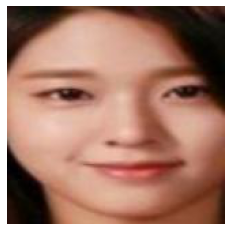

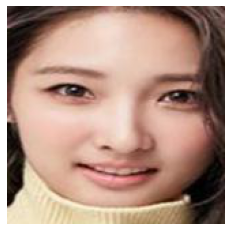

In [ ]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = (((image.numpy()*128)+127.5).transpose((1,2,0))).astype("int64")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

i = np.random.randint(low = 0, high = 23912)
print(f"{i:=}")
print(trainset[i][2])
imshow(trainset[i][0])
imshow(trainset[i][1])

In [ ]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
# Install PyTorch Facenet extension for Face Recognition Tasks
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 12.9 MB/s 


# Defining the Model
0. **MTCNN** - Used for Data Pre-processing, our data is "noisy", for facial recognition, we only need faces of people, but our images contain lot of background as well. This is a pre-trained intelligent algorithm, which recognizes faces in an image and intelligently crops the image to only include the facial region of a person to help us in facial recognition task and reduces the unnnecessary information in the images
1. **Pre-trained ResNet** - Our CNN Layer, takes in images as input, outputs vector embeddings of that image
2. **Neural Tensor Network (NTN)** - Takes in as input the vector embeddings of the two image pairs being compared and outputs a $K$ dimensional **similarity score vector** ($K$ is a hyperparameter) which stores raw similarity scores between the image pair. <a href = "https://proceedings.neurips.cc/paper/2013/file/b337e84de8752b27eda3a12363109e80-Paper.pdf">Neural Tensor Network paper</a>
3. **Feedforward Neural Network (FFNN)** - Vanilla Neural Networks which take in as input, the output of the NTN Layer and produces a 2 dimensional output of same person/not-same-person

In [ ]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, output_layer_dim):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        """
        super(NTNLayer, self).__init__()
        self.d = 512 # Input Dimension of the NTN
        self.k = output_layer_dim # Output dimension of the NTN
        self.params()
        self.initializeParams()

    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initializeParams(self):
        torch.nn.init.kaiming_normal_(self.W, a=0.1, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.V, a=0.1, nonlinearity='leaky_relu')
        torch.nn.init.kaiming_normal_(self.b, a=0.1, nonlinearity='leaky_relu')

    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Images
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Embedding of Image 1 - (B,D)
        :param: h2 : Embedding of Image 2 - (B,D)
        """
        B = h1.shape[0]
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K*D) -> (B, K*D)
        scores = scores.view(B,self.d,self.k) # (B,K*D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)

        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)

        leaky_relu = torch.nn.LeakyReLU(negative_slope = 0.1)
        scores = leaky_relu(scores)
        return scores

In [ ]:
from facenet_pytorch import InceptionResnetV1
import torch.nn.functional as F

class Flatten(torch.nn.Module):
        def __init__(self):
            super(Flatten, self).__init__()

        def forward(self, x):
            x = x.view(x.size(0), -1)
            return x
class normalize(torch.nn.Module):
    def __init__(self):
        super(normalize, self).__init__()

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

# Decoder Part of the Model, including the ResNet CNN Layer begins
class Decoder(torch.nn.Module):
    def __init__(self, ntn_output_dim = 128):
        super(Decoder, self).__init__() 
        self.ntn_output_dim = ntn_output_dim
        self.setupLayers()

    def setupResnet(self):
        # Downloading the Pre-trained ResNet CNN Layer
        model_ft = InceptionResnetV1(pretrained='vggface2', classify=False)

        # Listing all the final layers, which we are going to train
        layer_list = list(model_ft.children())[-5:]
        model_ft = torch.nn.Sequential(*list(model_ft.children())[:-5])

        # Since we just want to train final layers
        for param in model_ft.parameters():
            param.requires_grad = False

        # Re-attaching the final layers back to the model - automatically sets requires_grad = True
        model_ft.avgpool_1a = torch.nn.AdaptiveAvgPool2d(output_size=1)
        model_ft.last_linear = torch.nn.Sequential(Flatten(),
            torch.nn.Linear(in_features=1792, out_features=512, bias=False),
            normalize())

        return model_ft

    def setupLayers(self):
        # ResNet and Neural Tensor Network Layer
        self.resnet = self.setupResnet()
        self.NTN = NTNLayer(self.ntn_output_dim)

        # Linear Layers for the Final Output
        self.lin1 = torch.nn.Linear(self.ntn_output_dim,64)
        self.lin2 = torch.nn.Linear(64,32)
        self.lin3 = torch.nn.Linear(32,16)
        self.lin4 = torch.nn.Linear(16,8)
        self.lin5 = torch.nn.Linear(8,2)

    def FCNN(self, x):
        X = self.lin1(x)
        X = X.relu()
        X = self.lin2(X)
        X = X.relu()
        X = self.lin3(X)
        X = X.relu()
        X = self.lin4(X)
        X = X.relu()
        X = self.lin5(X)
        return X

    def rbfKernel(self, h1,h2):
        distance = h1-h2
        distance = torch.sum(distance*distance, dim = 1)
        return torch.exp(-distance).view(-1,1)

    def forward(self, X1, X2):
        # Passing input images through the ResNet to generate Image Embeddings
        h1 = self.resnet(X1)
        h2 = self.resnet(X2)

        # Passing the image embeddings via the NTN and the FCNN layer for predictions
        y_pred = self.NTN(h1, h2)
        y_pred = torch.cat((y_pred, self.rbfKernel(h1,h2)), dim=1)
        y_pred = self.FCNN(y_pred)

        return y_pred

# Training Begins

In [ ]:
def evaluate(loader):
    decoder.eval()
    correct = 0
    with torch.no_grad():
        for batch in loader:
            # Passing it via final encoder to get predictions
            y_pred = decoder(batch[0].to(device), batch[1].to(device))
            y_pred = y_pred.argmax(dim=1)
            correct += (y_pred == batch[2].view(-1).to(device)).sum()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    return correct / len(df)

In [ ]:
def train_batch(batch):
    # Passing it via final decoder to get predictions
    y_pred = decoder(batch[0].to(device), batch[1].to(device))

    loss = criterion(y_pred, batch[2].view(-1).to(device))
    loss.backward()
    opt.step()
    return loss.item()

In [ ]:
PATH_TO_MODEL = '/content/gdrive/My Drive/model.pth'

In [ ]:
decoder = Decoder()
# Choose whatever GPU device number you want
decoder.load_state_dict(torch.load(PATH_TO_MODEL, map_location="cuda:0"))
decoder.to(device)

In [ ]:
class_weights = [pos, 1-pos]
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean')
opt = torch.optim.AdamW(decoder.parameters(), lr = 0.005, weight_decay = 1e-5)

epochs = 3
for epoch in range(epochs):
    for i, batch in enumerate(trainloader):
        # Setting all the gradients to zero to prevent carry forward
        opt.zero_grad()
        decoder.train()
        loss = train_batch(batch)
        print(f'Epoch: {epoch+1:2d} | Iteration {i:3d}/{len(trainloader)} | Batch Loss = {loss:.6f}')

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    #print(f"Epoch: {epoch+1:2d} | Accuracy: {evaluate(trainloader):.6f}")

Epoch:  1 | Iteration   0/374 | Batch Loss = 0.487134
Epoch:  1 | Iteration   1/374 | Batch Loss = 0.290268
Epoch:  1 | Iteration   2/374 | Batch Loss = 0.192345
Epoch:  1 | Iteration   3/374 | Batch Loss = 0.240294
Epoch:  1 | Iteration   4/374 | Batch Loss = 0.311862
Epoch:  1 | Iteration   5/374 | Batch Loss = 0.349160
Epoch:  1 | Iteration   6/374 | Batch Loss = 0.204326
Epoch:  1 | Iteration   7/374 | Batch Loss = 0.223112
Epoch:  1 | Iteration   8/374 | Batch Loss = 0.227949
Epoch:  1 | Iteration   9/374 | Batch Loss = 0.241237
Epoch:  1 | Iteration  10/374 | Batch Loss = 0.212167
Epoch:  1 | Iteration  11/374 | Batch Loss = 0.281388
Epoch:  1 | Iteration  12/374 | Batch Loss = 0.282679
Epoch:  1 | Iteration  13/374 | Batch Loss = 0.456480
Epoch:  1 | Iteration  14/374 | Batch Loss = 0.263491
Epoch:  1 | Iteration  15/374 | Batch Loss = 0.233324
Epoch:  1 | Iteration  16/374 | Batch Loss = 0.370815
Epoch:  1 | Iteration  17/374 | Batch Loss = 0.250122
Epoch:  1 | Iteration  18/37

In [ ]:
evaluate(trainloader)

tensor(0.9355, device='cuda:0')

# Testing Begins

In [ ]:
class imagePairsTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file_dir, img_dir, transform = None):
        super(imagePairsTest, self).__init__()

        self.csv_file = pd.read_csv(os.path.join(root_dir, csv_file_dir))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img1_names = os.path.join(self.img_dir,self.csv_file.iloc[idx, 0])
        img2_names = os.path.join(self.img_dir, self.csv_file.iloc[idx, 1])

        # imread returns the numpy array of RGB values for the image. Shape = (H,W,3)
        image1 = io.imread(img1_names)
        image2 = io.imread(img2_names)

        sample = (image1, image2)

        if self.transform:
            sample = self.transform(sample)

        return sample

# Defining Image transforms - Image Preprocessing

# Rescaling Pair of Images together
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]

        h, w = image1.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image1 = skimage.transform.resize(image1, (new_h, new_w))


        h, w = image2.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image2 = skimage.transform.resize(image2, (new_h, new_w))

        return (image1, image2)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = torch.randint(0, h - new_h)
        left = torch.randint(0, w - new_w)

        image1 = image1[top: top + new_h, left: left + new_w]
        image2 = image2[top: top + new_h, left: left + new_w]

        return (image1, image2)

class Normalize(object):
    def __init__(self, mean = 127.5, std = 128.0):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]
        image1 = (image1-self.mean)/self.std
        image2 = (image2-self.mean)/self.std
        return (image1, image2)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image1, image2 = sample[0], sample[1]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image1 = image1.transpose((2, 0, 1))
        image2 = image2.transpose((2, 0, 1))
        return (torch.tensor(image1.copy(), dtype = torch.float32).contiguous(),
                torch.tensor(image2.copy(), dtype = torch.float32).contiguous())

In [ ]:
testset = imagePairsTest(root_dir = ROOT_DIR, csv_file_dir= TEST_DIR,
                     img_dir = '/content/cropped',
                     transform = transforms.Compose([Normalize(),ToTensor()]))

In [ ]:
batch_size = 64
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
predictions_list = []

def test_predict(loader):
    decoder.eval()
    with torch.no_grad():
        for batch in loader:
            # Passing it via final encoder to get predictions
            y_pred = decoder(batch[0].to(device), batch[1].to(device))
            y_pred = y_pred.argmax(dim=1).cpu().detach().numpy()
            predictions_list.extend(list(y_pred))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()


In [ ]:
df_test = pd.read_csv(os.path.join(ROOT_DIR, TEST_DIR))

In [ ]:
test_predict(testloader)

In [ ]:
df_test['label_pred'] = predictions_list

In [ ]:
df_test

,image1,image2,label_pred
0,84770376235978.jpg,70098827925517.jpg,0
1,51285551988172.jpg,40352160634341.jpg,1
2,92104157409800.jpg,43993355472481.jpg,1
3,17278801258247.jpg,39952763632406.jpg,0
4,69669552075188.jpg,11563244873988.jpg,0
...,...,...,...
4992,30470682361984.jpg,31915544799803.jpg,1
4993,38633214403572.jpg,17760910482671.jpg,0
4994,66870453878736.jpg,76054148475027.jpg,0
4995,25801526428363.jpg,47928524608159.jpg,1


In [ ]:
df_test.to_csv('predictions.csv')

# Demonstration of the Model Predictions

In [ ]:
import pandas as pd
import numpy as np

df_test = pd.read_csv('predictions.csv')

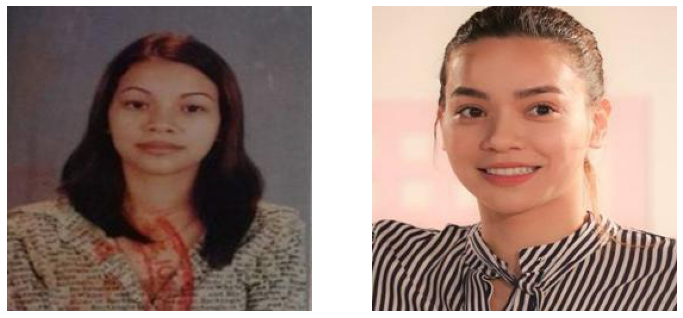

Example No. = 3608 | Same person!


In [ ]:
IMG_ROOT_DIR = os.path.join(ROOT_DIR, IMG_DIR)
from PIL import Image

def predict(i):
    img1 = np.array(Image.open(os.path.join(IMG_ROOT_DIR, df_test.iloc[i,1])))
    img2 = np.array(Image.open(os.path.join(IMG_ROOT_DIR, df_test.iloc[i,2])))

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,16))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

    # Getting predictions from the decoder model
    if df_test.iloc[i,3]:
        print(f"Example No. = {i+1} | Same person!")
    else:
        print(f'Example No. = {i+1} | Not the same person!')

i = np.random.randint(low = 0, high = len(df_test))
predict(i)


mtcnn(trainset[1][0], save_path = '../content/cropped/im.jpg')

from facenet_pytorch import MTCNN, InceptionResnetV1

batch_size = 64
image1_batch = []
image2_batch = []

# Batch transformation of all images into Tensors representing the Facial Area
for i in range(len(df)):
    img1 = trainset[i][0]
    img2 = trainset[i][1]
    label = trainset[i][2]

    image1_batch.append(img1)
    image2_batch.append(img2)
    label_batch.append(label)

    if (i+1)%batch_size == 0 or i==len(df)-1:
        faces1.extend(mtcnn(image1_batch))
        faces2.extend(mtcnn(image2_batch))
        image1_batch, image2_batch = [], []